In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob, sys
import sys
import xarray as xr
import dask.distributed
from matplotlib import colors as c
import pytide
import multiprocessing
import pandas as pd
import datetime
import seawater
import gsw

Read variable in a netcdf file. Function requires variable name, xaxis,yaxis and zaxis grid name.
mask file is also creating. Now the value greater than 2000 is used to create mask file. This value can set according to the model output. 2000 is given to consider density value which range 1000.
Timeseries values is converting to datetime64 format which is required for harmonic analysis in pytide package

In [2]:
def read_netcdf(variable_name,t_name,x_name,y_name,k_name):
    data_netcdf=xr.open_mfdataset('ROMS_*.nc', parallel=True, concat_dim=t_name, combine="nested",
                           data_vars='minimal', coords='minimal', compat='override')
    if variable_name == 'ZETA':
        data_netcdf_var=data_netcdf[variable_name][:,:,:].values
        mask=xr.where(data_netcdf_var[0,:,:]>2000, np.nan, 1)
    else:
        data_netcdf_var=data_netcdf[variable_name][:,:,:,:].values
        mask=xr.where(data_netcdf_var[0,:,:,:]>2000, np.nan, 1) 
    lon=data_netcdf[x_name][:].values
    lat=data_netcdf[y_name][:].values
    depth=data_netcdf[k_name][:].values
    time_value=data_netcdf[t_name].values.astype('datetime64[s]')
    
    xsize=lon.size
    ysize=lat.size
    zsize=depth.size
    tsize=time_value.size
    if variable_name == 'ZETA':
        zsize=1
    return data_netcdf_var, mask, time_value,lon,lat,depth,xsize,ysize,zsize,tsize

In [3]:
def nodal_modulations(wave_table, time_series):
   # """Compute nodal corrections for a given time series"""    
    #t = time_series.astype('datetime64[s]')
    waves_table = pytide.WaveTable(wave_table)
    f, v0u = waves_table.compute_nodal_modulations(time_series)
    return (f,v0u)

In [4]:
def Harmonic_analysis(mask,eta,f,v0u,wave_table):
    #if mask !=0:
    if mask ==1:
        #print ("Passed")
        waves_table = pytide.WaveTable(wave_table)
        w = waves_table.harmonic_analysis(eta, f, v0u)
        return w 
    return complex(0)

In [5]:
def splat_harmonic_analysis(args):
    return Harmonic_analysis(*args)

In [6]:
def parallel(var,input_timeseries,mask,xsize,ysize,zsize,eta,f,v0u,wave_table,processor_number):
    pool=multiprocessing.Pool(processor_number)
    if var == 'ZETA':
        analysis = pool.map(splat_harmonic_analysis,
                   ((mask[i,j],input_timeseries[:,i,j], f, v0u,wave_table) for i in range(ysize) for j in range(xsize)))
    else:
        analysis = pool.map(splat_harmonic_analysis,
                   ((mask[k,i,j],input_timeseries[:,k,i,j], f, v0u,wave_table) for k in range(zsize) for i in range(ysize) 
                   for j in range(xsize)))    
    return analysis

In [7]:
def create_netcdf(var,x,y,z,amp,pha):
    if var=='ZETA':
        z=[0.0]
        #amp=np.reshape(amp,[x.size,y.size,1])
        #pha=np.reshape(pha,[x.size,y.size,1])       
    ds = xr.Dataset(
        data_vars=dict(
            amp=(["depth","lat", "lon"], amp),
            pha=(["depth","lat", "lon"], pha)),
        coords=dict(
            lon=(["lon"], x),
            lat=(["lat"], y),
            depth=(["depth"], z),
        ),
        attrs=dict(description=var),
    )
    if var=='ZETA':
        ds.amp.attrs["units"] = "meters"
    elif var=='U' or var=='V':
        ds.amp.attrs["units"] = "m/s"
    else:
        ds.amp.attrs["units"] = "meters"            
    ds.pha.attrs["units"] = "degree"
    ds.lon.attrs["units"] = "degree_east"
    ds.lat.attrs["units"] = "degree_north"
    
    out_data=ds.to_netcdf(var+'.nc',"w")
    
    return out_data

In [8]:
def timeseries_constituents(wave_table,xsize,ysize,zsize,amp,pha):
    constituent=wave_table[0]
    if constituent=='M2':
        time=np.arange(13)
        tide =  np.reshape(amp,(1,zsize,ysize,xsize)) * np.sin((0.505636071* 
                                                     np.tile(time.reshape(13,1,1,1),
                                                                          (1,zsize,ysize,xsize)))- 
                                                    (np.reshape(pha,(1,zsize,ysize,xsize))*(np.pi/180.)))
    return tide

In [9]:
def create_netcdf_timeseries(wave_table,var,x,y,z,t,tide):
    constituent=wave_table[0]
    if constituent=='M2':
        t=t[0:13]
    if var=='ZETA':
        z=[0.0]    
    ds = xr.Dataset(
        data_vars=dict(
            tide=(["time","depth","lat", "lon"], tide),),
        coords=dict(
            lon=(["lon"], x),
            lat=(["lat"], y),
            depth=(["depth"], z),
            time=(["time"],t)
        ),
        attrs=dict(description=var),
    )
    if var=='ZETA':
        ds.tide.attrs["units"] = "meters"
    elif var=='U' or var=='V':
        ds.tide.attrs["units"] = "m/s"
    else:
        ds.tide.attrs["units"] = "meters"            
    ds.lon.attrs["units"] = "degree_east"
    ds.lat.attrs["units"] = "degree_north"
    
    out_data=ds.to_netcdf(var+'_timeseries.nc',"w")
    
    return out_data

In [10]:
def vertical_average(var,depth,mask,xsize,ysize):
    dz=np.append([1],(depth[1:]-depth[:-1]))  # dz value will start with [1,...]
    
    #  sum of ( variable* mask * dz) / sum of (dz*mask) 
    if len(var.shape) == 3:
        var_reshape=np.reshape(var,(1,dz.size,ysize,xsize))
    else:
        var_reshape=var

    depth_mean= np.nansum((var_reshape*(mask.reshape(1,dz.size,ysize,xsize)))*
                       (dz.reshape(1,dz.size,1,1)),axis=1)/np.nansum( (
        (dz.reshape(1,dz.size,1,1))* (mask.reshape(1,dz.size,ysize,xsize)) ),axis=1 )
    
    #depth_mean2= np.sum((var)*(dz.reshape(1,dz.size,1,1)),axis=1)/np.sum(dz)
    return(depth_mean)

In [11]:
def density_calculate(temp_name,salt_name,k_name,t_name,xsize,ysize,zsize):
    ds=xr.open_mfdataset('ROMS_*.nc', parallel=True, concat_dim=t_name, combine="nested",
                           data_vars='minimal', coords='minimal', compat='override')
    density=xr.apply_ufunc(gsw.density.rho, ds[salt_name], ds[temp_name],ds[k_name],  dask='parallelized')
    dens=density[:,:,:,:].values
    density_tmean=density.mean(dim=t_name).values
    temp_tmean=np.reshape(ds[temp_name].mean(dim=t_name).values,(1,zsize,ysize,xsize))
    salt_tmean=np.reshape(ds[salt_name].mean(dim=t_name).values,(1,zsize,ysize,xsize))
    return dens,density_tmean,temp_tmean,salt_tmean

In [12]:
def brunt_visala_calculate(salt,temp,depth,mask):
    n2=gsw.Nsquared(salt*mask,temp*mask,depth*mask,30)  #30 is the latitude, without this it showing some unrealistic values
    nsq=n2[0]
    nsq_negative_mask=np.where(nsq<0,np.nan,nsq)
    return nsq_negative_mask

def splat_n2(args):
    return brunt_visala_calculate(*args)

def parallel_n2(salt,temp,depth,mask,xsize,ysize,tsize,processor_number):
    pool=multiprocessing.Pool(processor_number)
    analysis = pool.map(splat_n2,
                   ((salt[t,:,i,j],temp[t,:,i,j],depth[:],mask[:,i,j]) for t in range(tsize) for i in range(ysize) 
                   for j in range(xsize)))
        
    return analysis

Equation of isopycnal displacement is 

$b = -g * (\rho - \rho_T)/\rho_Z$

$\eta = -b/N^2$

In [13]:
def isopycnal_displacement(nsq,density,density_tmean,density_zmean,mask,xsize,ysize,zsize,tsize):
    #eta_isopycnal= (9.8 * (density-density_tmean.reshape(1,zsize,ysize,xsize))/
    #            (density_zmean.reshape(1,1,ysize,xsize)))/(np.nanmean(nsq,axis=0))
    
    dens_at_nsq=density[:,1:,:,:]
    denstmean_at_nsq=density_tmean[1:,:,:]
    
    eta_isopycnal= (9.8 * (dens_at_nsq-denstmean_at_nsq.reshape(1,zsize-1,ysize,xsize))/
                (density_zmean.reshape(1,1,ysize,xsize)))/(np.nanmean(nsq,axis=0))
    
    return eta_isopycnal

In [14]:
if __name__ == '__main__':
    
    ### User defined NETCDF variable and axis names  This part is for U, V, and ZETA
    var_name ='U'
    var_tname='TIME'
    var_xname='LON_RHO385_409'
    var_yname='LAT_RHO122_146'
    var_zname='DEPTH'
    
    ### User defined tidal consituent
    wave_table=['M2'] 
    
    ##
    #mask=1
    
    processor_number=20 
    
    
    eta,mask,time,lon,lat,depth,xsize,ysize,zsize,tsize=read_netcdf(var_name,var_tname,var_xname,var_yname,var_zname)


    f,v0u=nodal_modulations(wave_table,time)
    
   
    analysis=parallel(var_name,eta,mask,xsize,ysize,zsize,eta,f,v0u,wave_table,processor_number)
    
    amp=np.absolute (np.reshape(np.array(analysis), (zsize,ysize,xsize)))
    
    pha=np.angle (np.reshape(np.array(analysis), (zsize,ysize,xsize)),deg=True)
     
    out=create_netcdf(var_name,lon,lat,depth,amp,pha)
    
    tide=timeseries_constituents(wave_table,xsize,ysize,zsize,amp,pha)

    create_netcdf_timeseries(wave_table,var_name,lon,lat,depth,time,tide)



In [15]:

if __name__ == '__main__':
    
    density,density_tmean,temp_tmean,salt_tmean=density_calculate("TEMP","SALT","DEPTH","TIME",xsize,ysize,zsize)
    
    density_zmean=vertical_average(density_tmean,depth,mask,xsize,ysize)
    
    ttsize=1
    nsq=np.reshape(np.array(parallel_n2(salt_tmean,temp_tmean,abs(depth),mask,xsize,ysize,ttsize,processor_number)),(ttsize,zsize-1,ysize,xsize))

    print(nsq.shape)
    eta_isopycnal=isopycnal_displacement(nsq,density,density_tmean,density_zmean,mask,xsize,ysize,zsize,tsize)
    
    

    
    


(1, 39, 25, 25)


In [16]:
!rm eta.nc
!rm eta_timeseries.nc
if __name__ == '__main__':

    var_name='eta'
    eta_tide=parallel(var_name,eta_isopycnal,mask,xsize,ysize,zsize-1,eta,f,v0u,wave_table,processor_number)
    
    eta_amp=np.absolute (np.reshape(np.array(eta_tide), (zsize-1,ysize,xsize)))
    
    eta_pha=np.angle (np.reshape(np.array(eta_tide), (zsize-1,ysize,xsize)),deg=True)
     
    out=create_netcdf(var_name,lon,lat,depth[1:],eta_amp,eta_pha)
    
    eta_tide=timeseries_constituents(wave_table,xsize,ysize,zsize-1,eta_amp,eta_pha)

    create_netcdf_timeseries(wave_table,var_name,lon,lat,depth[1:],time,eta_tide)

(1, 40, 25, 25)


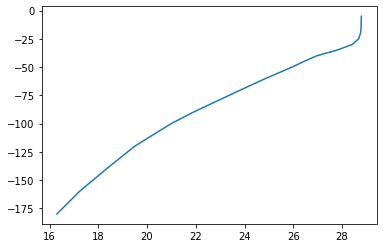

In [17]:
#plt.plot(temp_tmean[0,:,0,0],-1*depth)
#plt.plot(eta_isopycnal[0,:,19,19],-1*depth[1:])
print(temp_tmean.shape)
plt.plot(temp_tmean[0,:,19,19][1:20],-1*depth[:][1:20])

(720, 39, 25, 25)
1021.3021091790357
5.717467783219712e-07
80.0
23.862293
35.0406 12


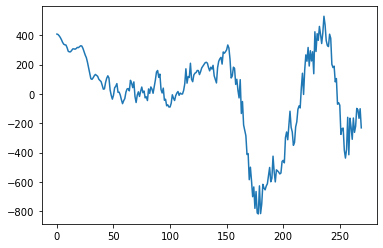

In [18]:
print(eta_isopycnal.shape)
#plt.plot(eta_isopycnal[:,1,0,0])

x_test=0
y_test=0
z_test=1

#plt.plot(eta_isopycnal[:,z_test,y_test,x_test])


#
#print(density_zmean.shape)

density_t=np.mean(density[30:300,z_test,y_test,x_test],axis=0)

print(density_t)

eta_test=(9.8* (density[30:300,z_test,y_test,x_test]-density_t)/(density_zmean[0,y_test,x_test]))/nsq[0,z_test,y_test,x_test]


#eta_test2=(9.8* (density[:,z_test,y_test,x_test]-/(density_zmean[0,y_test,x_test]))/nsq[0,z_test,y_test,x_test]


plt.plot(eta_test)

#plt.plot(density[:,z_test,y_test,x_test])
k=0
for k in range(38):
    if nsq[0,k,19,19] < 1e-6:
        print(nsq[0,k,19,19])
        print(depth[k+1])
        print(temp_tmean[0,k,19,19])        
        print(salt_tmean[0,k,19,19],k)
        

In [19]:
A=np.array([2,5,79,99,88,99])
B=np.array([0,2])

A[2::]

array([79, 99, 88, 99])

<xarray.DataArray 'amp' (depth: 12)>
array([0.278001, 0.306915, 0.256668, 0.247563, 0.26216 , 0.272501, 0.295495,
       0.254916, 0.245133, 0.135915, 0.066954, 0.025534])
Coordinates:
    lon      float32 85.416664
    lat      float32 6.5100756
  * depth    (depth) float32 500.0 600.0 725.0 850.0 ... 2500.0 3000.0 3500.0
Attributes:
    units:    meters
600.0


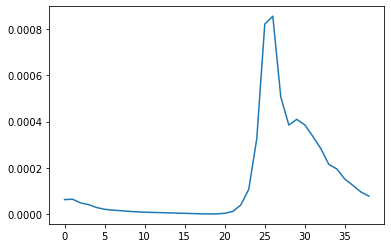

In [20]:
d_eta=xr.open_dataset('eta_timeseries.nc')
#print(d_eta["tide"].values.shape)
#plt.plot(d_eta["tide"][:,29:,0,20])

d_amp=xr.open_dataset('eta.nc')

print(d_amp["amp"][27:,0,20])
print(d_eta["depth"][28].values)
#plt.contourf(d_eta["tide"][:,:,0,20])

#plt.colorbar()

#plt.plot(d_amp["amp"][:,0,20])
nsqmean=np.nanmean(nsq,axis=0)

plt.plot(nsqmean[:,0,20])

#plt.plot(salt_mean[0,:,0,20],-1*depth)


In [22]:
p=np.array([1,np.nan,2,3])

print(np.nanmean(p))

2.0
